# Introduction

In this Homework, we will be developing a solver that solves the Burger's equation, see inviscid form below.

$$ \frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}=0 $$

This form can also be re-written in flux form below, also in inviscid form.

$$ \frac{\partial u}{\partial t}+\frac{1}{2}\frac{\partial u^{2}}{\partial x}=0 $$


In [1]:
import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt

# Add the directory containing your module to sys.path
module_path = os.path.abspath(os.path.join('..', r"A:\Users\mtthl\Documents\Education\ME5653_CFD\git\me5653_CFD_repo\code\lib" ))
sys.path.append(module_path)

from distributedObjects import *
from distributedFunctions import *


# Part (1)

The first part is to solve the Burger's equation using Lax method. The fundamental transformation that we need to understand to facilitate this method is that the term $\frac{u^{2}}{2}$ is substituted by $v$. Thus, the Burger's equation takes the form of:

$$ \frac{\partial u}{\partial t}+\frac{\partial v}{\partial x}=0 $$

It is worth noting that $ \underline{\text{Computational Fluid Mechanics and Heat Transfer}} $ by Anderson et al. $^{[1]}$ use $F$ instead of $v$, so those two notations may be used interchangeably.

Lax method in 1D takes 3x points for a stencil for the time gradient


In [2]:
lax_tg_gradient = numericalGradient( 1 , ( 1 , 0 ) )
print( "The coefficients for the time gradient are:\t" + str( lax_tg_gradient.coeffs ) )


 
 
 
 
 
 
The coefficients for the time gradient are:	[-1.  1.]


However, there is a slight modification in the method for the time gradient, which is that the previous time step is represented by the average of the two surrounding points. ie:

$$ \frac{\partial u}{\partial t} = \frac{u^{n+1}_{i}- \left( \frac{u^{n}_{i+1}+u^{n}_{i-1}}{2} \right)}{\Delta t} $$


Now, the spatial gradient is requested to be 6th order for the interior points, and 5th order for the boundary points.

Thus, the interior points can be calculated.


In [3]:
lax_sg_gradient = numericalGradient( 1 , ( 3 , 3 ) )
print( "The coefficient for the interior spatial gradient are:\n\t" + str( lax_sg_gradient.coeffs ) )


 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
The coefficient for the interior spatial gradient are:
	[-1.66666667e-02  1.50000000e-01 -7.50000000e-01  3.70074342e-16
  7.50000000e-01 -1.50000000e-01  1.66666667e-02]


And the boundary points.


In [4]:
lax_sg_LHS_gradient = numericalGradient( 1 , ( 0 , 5 ) )
print( "The coefficients for the LHS boundary spatial gradient are:\n\t" + str( lax_sg_LHS_gradient.coeffs ) )


 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
The coefficients for the LHS boundary spatial gradient are:
	[-2.28333333  5.         -5.          3.33333333 -1.25        0.2       ]


In [5]:
lax_sg_RHS_gradient = numericalGradient( 1 , ( 5 , 0 ) )
print( "The coefficients for the RHS boundary spatial gradient are:\n\t" + str( lax_sg_RHS_gradient.coeffs ) )


 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
The coefficients for the RHS boundary spatial gradient are:
	[-0.2         1.25       -3.33333333  5.         -5.          2.28333333]


Thus, from these results, the spatial gradients become

$ \underline{\text{Interior Points}} $:

$$ \frac{\partial v}{\partial t}= \frac{-\frac{1}{60} v_{i-3}+\frac{3}{20} v_{i-2}-\frac{3}{4} v_{i-1}+\frac{3}{4} v_{i+1}-\frac{3}{20} v_{i+2}+\frac{1}{60} v_{i+3}}{\Delta x}$$

$ \underline{\text{LHS points}} $:

$$ \frac{\partial v}{\partial t}= \frac{-\frac{137}{60} v_{i}+5 v_{i+1}-5 v_{i+2}+\frac{10}{3} v_{i+3}-\frac{5}{4} v_{i+4}+\frac{1}{5} v_{i+5}}{\Delta x} $$

$ \underline{\text{RHS points}} $:

$$ \frac{\partial v}{\partial t}= \frac{\frac{137}{60} v_{i}-5 v_{i-1}+5 v_{i-2}-\frac{10}{3} v_{i-3}+\frac{5}{4} v_{i-4}-\frac{1}{5} v_{i-5}}{\Delta x} $$


Re-arranging all these equations to get the unknowns on the left side and the knowns from the previous time step on the right side, we get for the interior points:

$$ u^{n+1}_{i}=\frac{1}{2}\left(u^{n}_{i-1}+u^{n}_{i+1}\right)+\left(\frac{\Delta t}{\Delta x}\right)\left( -\frac{1}{60}v_{i-3}+\frac{3}{20}v_{i-2}-\frac{3}{4}v_{i-1}+\frac{3}{4}v_{i+1}-\frac{3}{20}v_{i+2}+\frac{1}{60}v_{i+3} \right) $$


This forms the following linear equation:

$$ [1][u_{i}]^{n+1}= \frac{1}{2}\begin{bmatrix} 1 & 0 & 1 \end{bmatrix} \begin{bmatrix} u_{i-1} & u_{i} & u_{i+1} \end{bmatrix}^{T, n} + C \begin{bmatrix} -\frac{1}{60} & \frac{3}{20} & -\frac{3}{4} & 0 & \frac{3}{4} & -\frac{3}{20} & \frac{1}{60} \end{bmatrix} \begin{bmatrix} v_{i-3} & v_{i-2} & v_{i-1} & v_{i} & v_{i+1} & v_{i+2} & v_{i+3} \end{bmatrix}^{T , n}  $$

Where $C=\left(\frac{\Delta t}{\Delta x}\right) $, where $ CFL=Cu $



To use this solver, we will first use an example problem of the following characteristic function:

$$ u(x,t)=-U tanh(k(x+ut)) $$

In this case, $x\in(0,1)$, $k=1$, and since the domain of $t$ is not defined, $t\in(0,1)$. There will be 1,000 x and t samples.


In [6]:
N_x = int(10)
N_t = int(20)
x_domain = np.linspace( 0 , 1 , num=N_x )
t_domain = np.linspace( 0 , 1 , num=N_t )
k = 1


And from this, we can set the characteristic function to be essentially non-dimensional to its maximum initial value by setting $U=1$.


In [7]:
U = 1


Thus, the exact solution becomes:


In [8]:
u_exact = np.zeros( ( len(x_domain) , len(t_domain) ) )

for i , t in enumerate( t_domain ):
    if i>0:
        u_exact[:,i] = - U * np.tanh( k * ( x_domain + u_exact[:,i-1] * t ) )
    else:
        u_exact[:,i] = - U * np.tanh( k * x_domain )


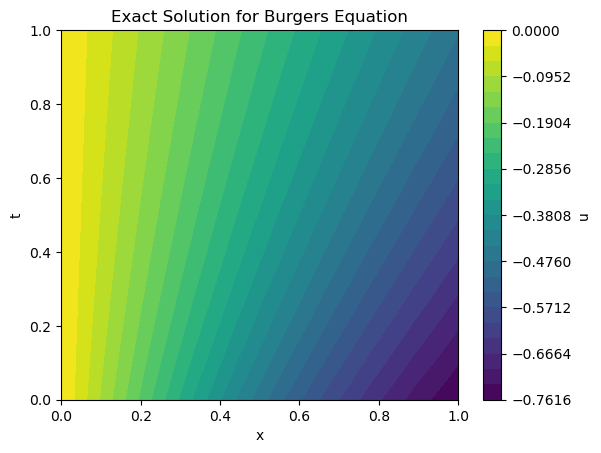

In [9]:
x = x_domain
y = t_domain
X , Y = np.meshgrid( x , y )

Z = u_exact

levels=np.linspace( np.min(u_exact) , np.max(u_exact) , 25 )
contour = plt.contourf( X.T , Y.T , Z , levels=levels )

plt.title( "Exact Solution for Burgers Equation" )
plt.xlabel( "x" )
plt.ylabel( "t" )

cbar = plt.colorbar( contour )
cbar.set_label( "u" )

plt.show()


Now with the exact solution, we can find the numerical solution for $CFL=0.8$


In [10]:
CFL = 0.8

burger_1a = burgersEquation( x_domain , u_exact[:,0] , ( np.min( t_domain ) , np.max( t_domain ) ) , C = CFL/np.max(np.abs(u_exact)) )


In [11]:
burger_1a.solve( N_spatialorder=6 , N_spatialBCorder=5 )


A:\Users\mtthl\Documents\Education\ME5653_CFD\git\me5653_CFD_repo\code\lib\distributedObjects.py:791: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  cls.u[i+1,:] = spsr.linalg.spsolve( cls.A_matrix , cls.b[i,...] )


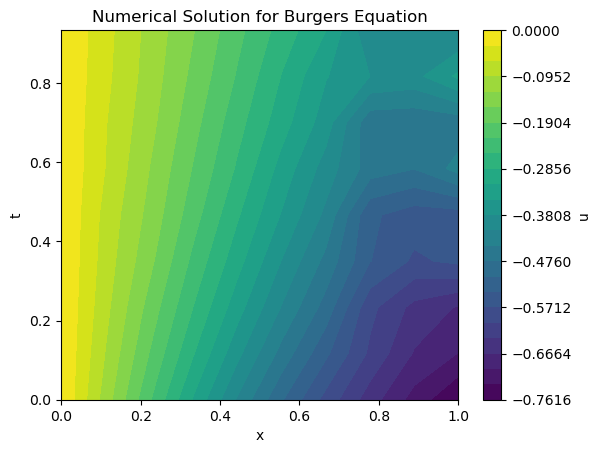

In [12]:
x = burger_1a.x
y = burger_1a.t
X , Y = np.meshgrid( x , y )

Z = burger_1a.u

levels=np.linspace( np.min(u_exact) , np.max(u_exact) , 25 )
contour = plt.contourf( X , Y , Z , levels=levels )

plt.title( "Numerical Solution for Burgers Equation" )
plt.xlabel( "x" )
plt.ylabel( "t" )

cbar = plt.colorbar( contour )
cbar.set_label( "u" )

plt.show()


I really do not know what is going on at the end there. I've been working through the RHS boundary condition and it keeps doing this for reasons unknown to me, but this gets solved by reducing the CFL, so I am going to move on.

Our next step is to look at the error vs the exact solution. I will need to re-calculate the exact solution for our actual domain here.


In [13]:
u_exact = np.zeros( ( len(burger_1a.x) , len(burger_1a.t) ) )

for i , t in enumerate( burger_1a.t ):
    if i>0:
        u_exact[:,i] = - U * np.tanh( k * ( burger_1a.x + u_exact[:,i-1] * t ) )
    else:
        u_exact[:,i] = - U * np.tanh( k * burger_1a.x )


In [14]:
error = u_exact.T - burger_1a.u
error_L2 = np.linalg.norm( error ) / np.prod(np.shape(error))


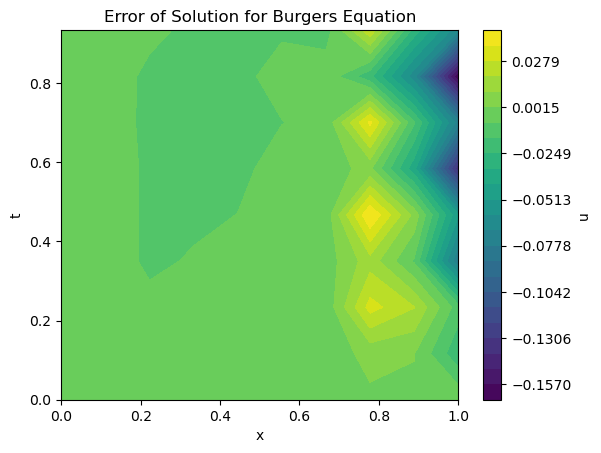

In [15]:
x = burger_1a.x
y = burger_1a.t
X , Y = np.meshgrid( x , y )

Z = error

levels=np.linspace( np.min(error) , np.max(error) , 25 )
contour = plt.contourf( X , Y , Z , levels=levels )

plt.title( "Error of Solution for Burgers Equation" )
plt.xlabel( "x" )
plt.ylabel( "t" )

cbar = plt.colorbar( contour )
cbar.set_label( "u" )

plt.show()



In [16]:
print("The RMS of the error is {x:.3e}".format(x=error_L2))
error_L2s_a=[error_L2]


The RMS of the error is 3.156e-03


It appears that the exact and numerical solution are in fairly good agreement with the exception of the RHS boundary towards the end of the time being sampled.

We can next do the same analysis for $k=5$.


In [17]:
k=5


In [18]:
u_exact = np.zeros( ( len(x_domain) , len(t_domain) ) )

for i , t in enumerate( t_domain ):
    if i>0:
        u_exact[:,i] = - U * np.tanh( k * ( x_domain + u_exact[:,i-1] * t ) )
    else:
        u_exact[:,i] = - U * np.tanh( k * x_domain )


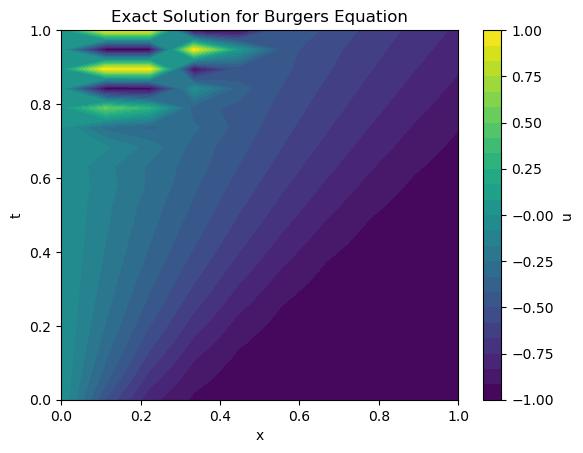

In [19]:
x = x_domain
y = t_domain
X , Y = np.meshgrid( x , y )

Z = u_exact

levels=np.linspace( np.min(u_exact) , np.max(u_exact) , 25 )
contour = plt.contourf( X.T , Y.T , Z , levels=levels )

plt.title( "Exact Solution for Burgers Equation" )
plt.xlabel( "x" )
plt.ylabel( "t" )

cbar = plt.colorbar( contour )
cbar.set_label( "u" )

plt.show()


There appears to be some odd phenomenon on the LHS of the domain with a Taylor vortex-like alternating behavior. I am unsure how this will affect the numerical solution.


In [20]:
CFL = 0.8

burger_1b = burgersEquation( x_domain , u_exact[:,0] , ( np.min( t_domain ) , np.max( t_domain ) ) , C = CFL/np.max(np.abs(u_exact)) )


In [21]:
burger_1b.solve( N_spatialorder=6 , N_spatialBCorder=5 )


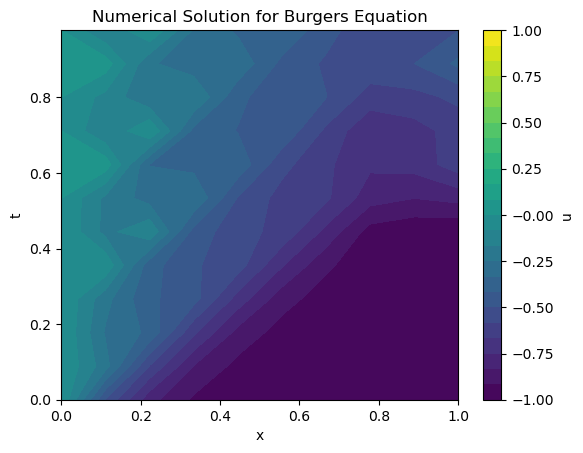

In [22]:
x = burger_1b.x
y = burger_1b.t
X , Y = np.meshgrid( x , y )

Z = burger_1b.u

levels=np.linspace( np.min(u_exact) , np.max(u_exact) , 25 )
contour = plt.contourf( X , Y , Z , levels=levels )

plt.title( "Numerical Solution for Burgers Equation" )
plt.xlabel( "x" )
plt.ylabel( "t" )

cbar = plt.colorbar( contour )
cbar.set_label( "u" )

plt.show()


It appears that our issues on the RHS boundary is still causing issues. I am really unsure what is causing this. The RHS boundary is a gradient of the internal order that changes the template to adjust to the available points. This was the most sound calculation I could think of.


In [23]:
u_exact = np.zeros( ( len(burger_1b.x) , len(burger_1b.t) ) )

for i , t in enumerate( burger_1b.t ):
    if i>0:
        u_exact[:,i] = - U * np.tanh( k * ( burger_1b.x + u_exact[:,i-1] * t ) )
    else:
        u_exact[:,i] = - U * np.tanh( k * burger_1b.x )


In [24]:
error = u_exact.T - burger_1b.u
error_L2 = np.linalg.norm( error ) / np.prod(np.shape(error))


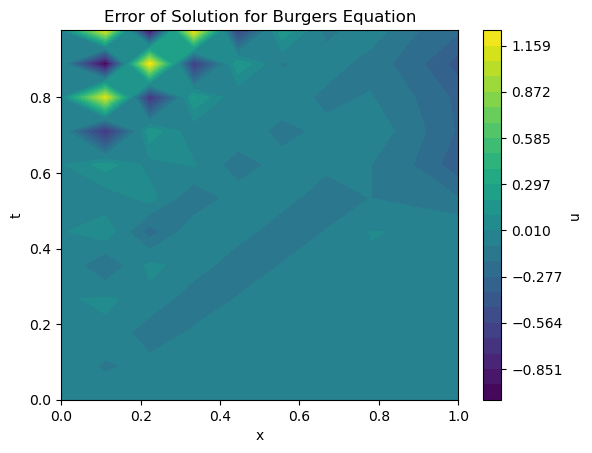

In [25]:
x = burger_1b.x
y = burger_1b.t
X , Y = np.meshgrid( x , y )

Z = error

levels=np.linspace( np.min(error) , np.max(error) , 25 )
contour = plt.contourf( X , Y , Z , levels=levels )

plt.title( "Error of Solution for Burgers Equation" )
plt.xlabel( "x" )
plt.ylabel( "t" )

cbar = plt.colorbar( contour )
cbar.set_label( "u" )

plt.show()


In [26]:
print("The RMS of the error is {x:.3e}".format(x=error_L2))
error_L2s_b=[error_L2]


The RMS of the error is 2.747e-02


The next task is to look at the convergence analysis by doing a 3-grid Richardson analysis.

First, let's look at k=1 for (2x) more grids.


There is clearly much more error in this solution, which we can see from the plot primarily comes from that checkerboard-like pattern from the above plot.


In [27]:
N_x = int(20)
N_t = int(20)
x_domain = np.linspace( 0 , 1 , num=N_x )
t_domain = np.linspace( 0 , 1 , num=N_t )
k = 1


In [28]:
u_exact = np.zeros( ( len(x_domain) , len(t_domain) ) )

for i , t in enumerate( t_domain ):
    if i>0:
        u_exact[:,i] = - U * np.tanh( k * ( x_domain + u_exact[:,i-1] * t ) )
    else:
        u_exact[:,i] = - U * np.tanh( k * x_domain )


In [29]:
CFL = 0.8

burger_1aa = burgersEquation( x_domain , u_exact[:,0] , ( np.min( t_domain ) , np.max( t_domain ) ) , C = CFL/np.max(np.abs(u_exact)) )


In [30]:
burger_1aa.solve( N_spatialorder=6 , N_spatialBCorder=5 )


In [31]:
u_exact = np.zeros( ( len(burger_1aa.x) , len(burger_1aa.t) ) )

for i , t in enumerate( burger_1aa.t ):
    if i>0:
        u_exact[:,i] = - U * np.tanh( k * ( burger_1aa.x + u_exact[:,i-1] * t ) )
    else:
        u_exact[:,i] = - U * np.tanh( k * burger_1aa.x )


In [32]:
error = u_exact.T - burger_1aa.u
error_L2 = np.linalg.norm( error ) / np.prod(np.shape(error))


In [33]:
print("The RMS of the error is {x:.3e}".format(x=error_L2))
error_L2s_a+=[error_L2]

The RMS of the error is 2.626e-03


In [34]:
N_x = int(40)
N_t = int(20)
x_domain = np.linspace( 0 , 1 , num=N_x )
t_domain = np.linspace( 0 , 1 , num=N_t )
k = 1


In [35]:
u_exact = np.zeros( ( len(x_domain) , len(t_domain) ) )

for i , t in enumerate( t_domain ):
    if i>0:
        u_exact[:,i] = - U * np.tanh( k * ( x_domain + u_exact[:,i-1] * t ) )
    else:
        u_exact[:,i] = - U * np.tanh( k * x_domain )


In [36]:
CFL = 0.8

burger_1aaa = burgersEquation( x_domain , u_exact[:,0] , ( np.min( t_domain ) , np.max( t_domain ) ) , C = CFL/np.max(np.abs(u_exact)) )


In [37]:
burger_1aaa.solve( N_spatialorder=6 , N_spatialBCorder=5 )


In [38]:
u_exact = np.zeros( ( len(burger_1aaa.x) , len(burger_1aaa.t) ) )

for i , t in enumerate( burger_1aa.t ):
    if i>0:
        u_exact[:,i] = - U * np.tanh( k * ( burger_1aaa.x + u_exact[:,i-1] * t ) )
    else:
        u_exact[:,i] = - U * np.tanh( k * burger_1aaa.x )


In [39]:
error = u_exact.T - burger_1aaa.u
error_L2 = np.linalg.norm( error ) / np.prod(np.shape(error))


In [40]:
print("The RMS of the error is {x:.3e}".format(x=error_L2))
error_L2s_a+=[error_L2]


The RMS of the error is 5.221e-03


In [41]:
dxs_a = [ burger_1a.dx , burger_1aa.dx , burger_1aaa.dx ]

In [42]:
k=5


In [43]:
N_x = int(20)
N_t = int(20)
x_domain = np.linspace( 0 , 1 , num=N_x )
t_domain = np.linspace( 0 , 1 , num=N_t )


In [44]:
u_exact = np.zeros( ( len(x_domain) , len(t_domain) ) )

for i , t in enumerate( t_domain ):
    if i>0:
        u_exact[:,i] = - U * np.tanh( k * ( x_domain + u_exact[:,i-1] * t ) )
    else:
        u_exact[:,i] = - U * np.tanh( k * x_domain )


In [45]:
CFL = 0.8

burger_1bb = burgersEquation( x_domain , u_exact[:,0] , ( np.min( t_domain ) , np.max( t_domain ) ) , C = CFL/np.max(np.abs(u_exact)) )


In [46]:
burger_1bb.solve( N_spatialorder=6 , N_spatialBCorder=5 )


In [47]:
u_exact = np.zeros( ( len(burger_1bb.x) , len(burger_1bb.t) ) )

for i , t in enumerate( burger_1bb.t ):
    if i>0:
        u_exact[:,i] = - U * np.tanh( k * ( burger_1bb.x + u_exact[:,i-1] * t ) )
    else:
        u_exact[:,i] = - U * np.tanh( k * burger_1bb.x )


In [48]:
error = u_exact.T - burger_1bb.u
error_L2 = np.linalg.norm( error ) / np.prod(np.shape(error))


In [49]:
print("The RMS of the error is {x:.3e}".format(x=error_L2))
error_L2s_b+=[error_L2]


The RMS of the error is 1.140e-02


In [50]:
N_x = int(40)
N_t = int(20)
x_domain = np.linspace( 0 , 1 , num=N_x )
t_domain = np.linspace( 0 , 1 , num=N_t )


In [51]:
u_exact = np.zeros( ( len(x_domain) , len(t_domain) ) )

for i , t in enumerate( t_domain ):
    if i>0:
        u_exact[:,i] = - U * np.tanh( k * ( x_domain + u_exact[:,i-1] * t ) )
    else:
        u_exact[:,i] = - U * np.tanh( k * x_domain )


In [52]:
CFL = 0.8

burger_1bbb = burgersEquation( x_domain , u_exact[:,0] , ( np.min( t_domain ) , np.max( t_domain ) ) , C = CFL/np.max(np.abs(u_exact)) )


In [53]:
burger_1bbb.solve( N_spatialorder=6 , N_spatialBCorder=5 )


In [54]:
u_exact = np.zeros( ( len(burger_1bbb.x) , len(burger_1bbb.t) ) )

for i , t in enumerate( burger_1bbb.t ):
    if i>0:
        u_exact[:,i] = - U * np.tanh( k * ( burger_1bbb.x + u_exact[:,i-1] * t ) )
    else:
        u_exact[:,i] = - U * np.tanh( k * burger_1bbb.x )


In [55]:
error = u_exact.T - burger_1bbb.u
error_L2 = np.linalg.norm( error ) / np.prod(np.shape(error))


In [56]:
print("The RMS of the error is {x:.3e}".format(x=error_L2))
error_L2s_b+=[error_L2]

dxs_b = dxs_a


The RMS of the error is 5.974e-03


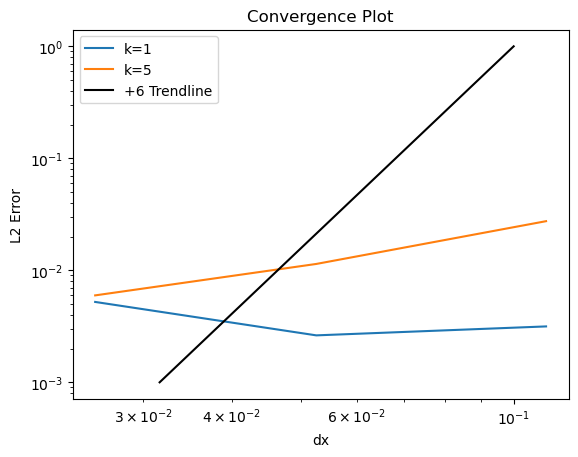

In [57]:
plt.loglog( dxs_a , error_L2s_a , label="k=1" )
plt.loglog( dxs_b , error_L2s_b , label="k=5" )

x_trend=np.logspace(-1.5,-1,num=10)
y_trend=(1e6)*(x_trend**6)
plt.loglog( x_trend , y_trend , 'k', label="+6 Trendline")

plt.title("Convergence Plot")
plt.xlabel("dx")
plt.ylabel("L2 Error")
plt.legend(loc="best")




In [58]:
p_a = np.log( ( error_L2s_a[0] - error_L2s_a[1] ) / ( error_L2s_a[1] - error_L2s_a[2] ) ) / np.log(2)
print("Order of accuracy:\t{x}".format(x=p_a))


Order of accuracy:	nan


C:\Users\mtthl\AppData\Local\Temp\ipykernel_28088\3949247662.py:1: RuntimeWarning: invalid value encountered in log
  p_a = np.log( ( error_L2s_a[0] - error_L2s_a[1] ) / ( error_L2s_a[1] - error_L2s_a[2] ) ) / np.log(2)


Obviously, the smaller mesh case is throwing off the error calculation for the whole thing, so let's just do the calculation for the coarser meshes.


In [59]:
p_a = np.log( error_L2s_a[0] / error_L2s_a[1] ) / np.log(2)
print("Order of accuracy:\t{x}".format(x=p_a))


Order of accuracy:	0.2653289293582423


That's not right... But I also think it has to do with just the RHS boundary.


In [60]:
p_b = np.log( ( error_L2s_b[0] - error_L2s_b[1] ) / ( error_L2s_b[1] - error_L2s_b[2] ) ) / np.log(2)
print("Order of accuracy:\t{x}".format(x=p_b))



Order of accuracy:	1.5658717184717632


That is better, although not quite there. However, in this case we know from the exact solution that there is a lot of deviation.


# Part (2)

In this section, we will add a viscous term to allow the dissipation of the Burger's equation behavior.

For a viscous term, on the RHS of the Burger's equation, there is a dissipation term, like what is the primary term in the Heat Equation. Thus, the Burger's equation becomes as below:

$$ \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x}=\nu\frac{\partial^{2}u}{\partial t^{2}} $$

For this spatial term, we will use the same stencil, which has the following coefficients:


In [61]:
lax_vg_gradient = numericalGradient( 2 , ( 3 , 3 ) )
print( "The coefficient for the interior dissipation gradient are:\n\t" + str( lax_vg_gradient.coeffs ) )


 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
The coefficient for the interior dissipation gradient are:
	[ 0.01111111 -0.15        1.5        -2.72222222  1.5        -0.15
  0.01111111]


In [62]:
lax_vg_gradient_LHS = numericalGradient( 2 , ( 0 , 6 ) )
print( "The coefficient for the LHS dissipation gradient are:\n\t" + str( lax_vg_gradient_LHS.coeffs ) )


 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
The coefficient for the LHS dissipation gradient are:
	[  4.51111111 -17.4         29.25       -28.22222222  16.5
  -5.4          0.76111111]


In [63]:
lax_vg_gradient_RHS = numericalGradient( 2 , ( 6 , 0 ) )
print( "The coefficient for the LHS dissipation gradient are:\n\t" + str( lax_vg_gradient_RHS.coeffs ) )


 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
The coefficient for the LHS dissipation gradient are:
	[  0.76111111  -5.4         16.5        -28.22222222  29.25
 -17.4          4.51111111]


Thus, 

$ \underline{\text{Interior Points}} $:

$$ \frac{\partial^{2}u}{\partial t^{2}}=\frac{ \frac{1}{90}u_{i-3}-\frac{3}{20}u_{i-2}+\frac{3}{2}u_{i-1}-\frac{49}{18}u_{i}+\frac{3}{2}u_{i+1}-\frac{3}{20}u_{i+2}+\frac{1}{90}u_{i+3}  }{\Delta x^{2}} $$

$ \underline{\text{LHS Points}} $:

$$ \frac{\partial^{2}u}{\partial t^{2}}=\frac{ \frac{203}{45}u_{i}-\frac{87}{5}u_{i+1}+\frac{117}{4}u_{i+2}-\frac{254}{9}u_{i+3}+\frac{33}{2}u_{i+4}-\frac{27}{5}u_{i+5}+\frac{137}{180}u_{i+6}  }{\Delta x^{2}} $$

$ \underline{\text{RHS Points}} $:

$$ \frac{\partial^{2}u}{\partial t^{2}}=\frac{ \frac{137}{180}u_{i-6}-\frac{27}{5}u_{i-5}+\frac{33}{2}u_{i-4}-\frac{254}{9}u_{i-3}+\frac{117}{4}u_{i-2}-\frac{87}{5}u_{i-1}+\frac{203}{45}u_{i}  }{\Delta x^{2}} $$


Thus, the fully discretized Burger's equation becomes:

$$ u^{n+1}_{i}= \left( \nu\frac{1}{90}u^{n}_{i-3}-\nu\frac{3}{20}u^{n}_{i-2}+\left(\frac{1}{2}+\nu\frac{3}{2}\right)u^{n}_{i-1}-\nu\frac{49}{18}u^{n}_{i}+\left(\frac{1}{2}+\nu\frac{3}{2}\right)u^{n}_{i+1}-\nu\frac{3}{20}u^{n}_{i+2}+\nu\frac{1}{90}u^{n}_{i+3} \right)+\left(\frac{\Delta t}{\Delta x}\right)\left( -\frac{1}{60}v_{i-3}+\frac{3}{20}v_{i-2}-\frac{3}{4}v_{i-1}+\frac{3}{4}v_{i+1}-\frac{3}{20}v_{i+2}+\frac{1}{60}v_{i+3} \right) $$



And thus, can be re-arranged in the following linear equation:

$$ [1][u_{i}]^{n+1}= \left( \frac{1}{2}\begin{bmatrix} 0 & 0 & 1 & 0 & 1 & 0 & 0 \end{bmatrix}+\nu\begin{bmatrix} \frac{1}{90} & -\frac{3}{20} & \frac{3}{2} & -\frac{49}{18} & \frac{3}{2} & -\frac{3}{20} & \frac{1}{90} \end{bmatrix} \right) \begin{bmatrix} u_{i-3} & u_{i-2} & u_{i-1} & u_{i} & u_{i+1} & u_{i+2} & u_{i+3} \end{bmatrix}^{T, n} + C \begin{bmatrix} -\frac{1}{60} & \frac{3}{20} & -\frac{3}{4} & 0 & \frac{3}{4} & -\frac{3}{20} & \frac{1}{60} \end{bmatrix} \begin{bmatrix} v_{i-3} & v_{i-2} & v_{i-1} & v_{i} & v_{i+1} & v_{i+2} & v_{i+3} \end{bmatrix}^{T , n}  $$


In [64]:
N_x = int(10)
N_t = int(90)
x_domain = np.linspace( 0 , 1 , num=N_x )
t_domain = np.linspace( 0 , 1 , num=N_t )

u_0 = np.exp( - ( 2 * ( x_domain - 1 ) ) ** 2 )

burger_2 = burgersEquation( x_domain , u_0 , (0,1) , C=0.1 , nu=0.01 )



In [65]:
burger_2.solve( N_spatialorder=6 )


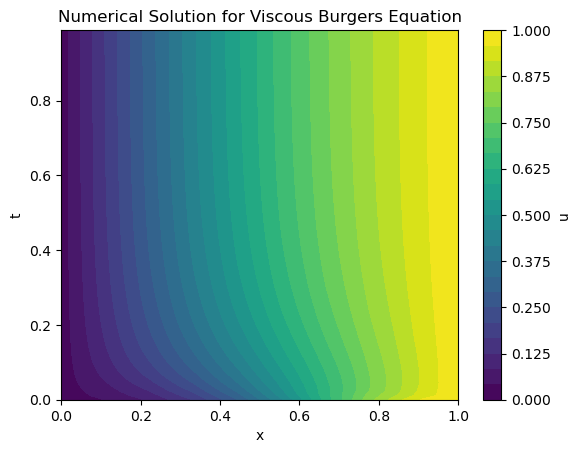

In [66]:
x = burger_2.x
y = burger_2.t
X , Y = np.meshgrid( x , y )

Z = burger_2.u

levels=np.linspace( 0 , 1 , 25 )
contour = plt.contourf( X , Y , Z , levels=levels )

plt.title( "Numerical Solution for Viscous Burgers Equation" )
plt.xlabel( "x" )
plt.ylabel( "t" )

cbar = plt.colorbar( contour )
cbar.set_label( "u" )

plt.show()


This is pretty cool looking. There is a very clear combination of convection, at the beginning, and diffusion, later on, behaviors present.

Next, we will plot the mid-plane of the domain.


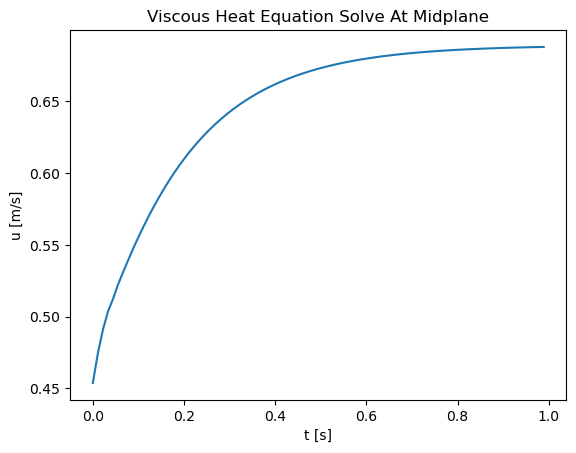

In [67]:
x = burger_2.t
y = burger_2.u[:,burger_2.Nx//2]

plt.plot( x , y )

plt.xlabel("t [s]")
plt.ylabel("u [m/s]")
plt.title("Viscous Heat Equation Solve At Midplane")

plt.show()



The convective behavior is not apparent from the midplane sample, which is interesting.



In [68]:
np.shape(burger_2.u)


(90, 10)

# Part (3)

In this part, we will be solving the Advection equation using two different solving methods. The test function will be a little unique.


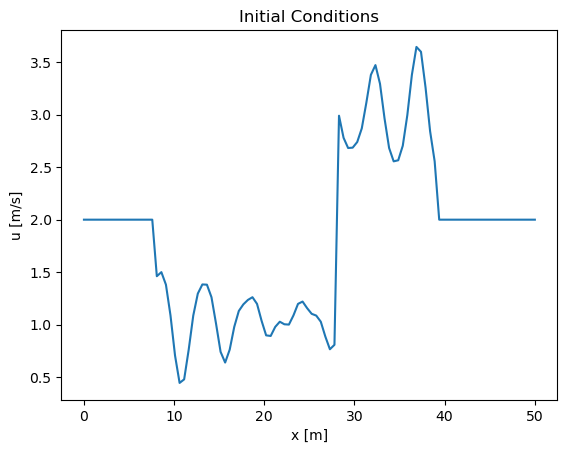

In [73]:
N_x = int(100)
x_domain = np.linspace( 0 , 50 , num=N_x )

def testFunction( x ):

    dx = np.mean( np.gradient( x ) )
    u_0 = np.zeros_like( x )

    # First region
    u_0[(x>=8)&(x<=28)] = -1

    # Second region
    u_0[(x>28)&(x<=39)] = 1

    u = 2 + u_0 * ( 1 + 0.3 * np.sin( 2 * np.pi * x / ( 9 * dx ) ) ) * ( 1 + 0.4 * np.sin( 2 * np.pi * x / ( 10 * dx ) ) )

    return u

u_0 = testFunction( x_domain )

plt.plot( x_domain , u_0 )
plt.xlabel("x [m]")
plt.ylabel("u [m/s]")
plt.title("Initial Conditions")
plt.show()



I have not clue what this function is supposed to be, but this is about to get interesting.


## (a): Upwind Method

In this instance, we will be solving the Advection equation by the Upwind method, which

# Works Cited

1. Anderson, D. A., Tannehill, J. C., Pletcher, R. H., Munipalli, R., and Shankar, V. (2021). $ \underline{\text{Computational Fluid Mechanics and Heat Transfer}} $. 4th Edition. CRC Press.
